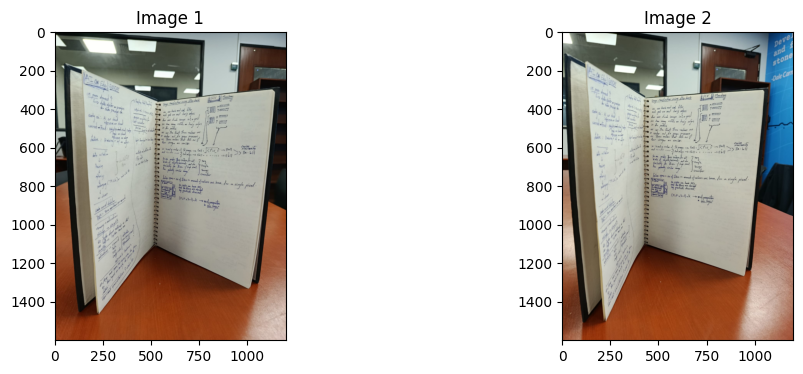

Good matches: 1367


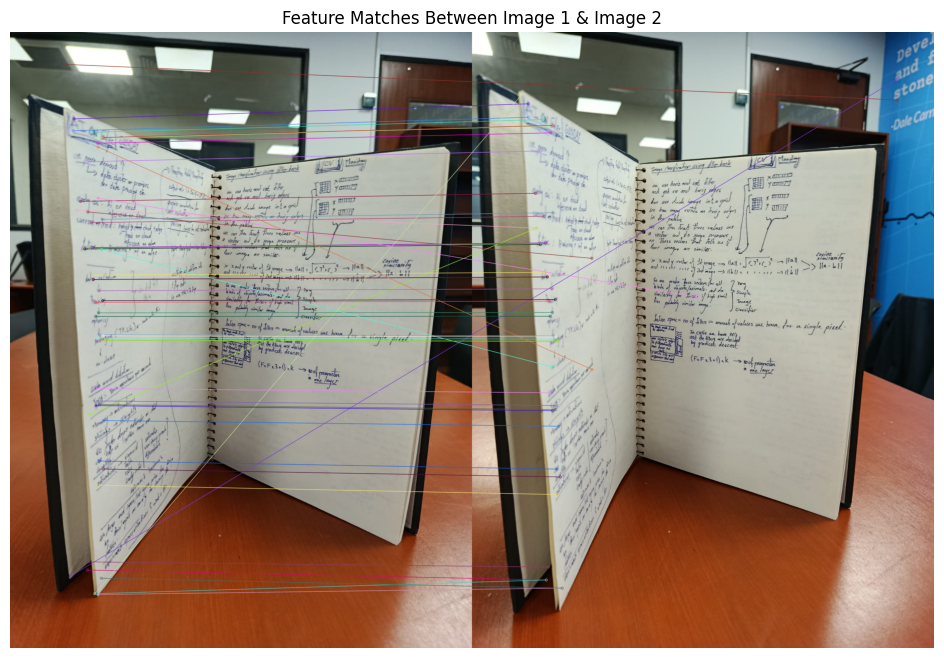

Image size: 1200 × 1600 pixels

Camera parameters:
  Actual focal length: 5.03mm
  Sensor size: 7.26 × 5.44mm
  Focal length in pixels: fx=831.4, fy=1478.1

Intrinsic matrix K:
[[8.31410e+02 0.00000e+00 6.00000e+02]
 [0.00000e+00 1.47806e+03 8.00000e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]

RANSAC inliers: 1195 out of 1367

Rotation matrix R:
[[ 0.9912  0.0228 -0.1302]
 [-0.0241  0.9997 -0.0084]
 [ 0.13    0.0115  0.9914]]

Translation vector t (unit norm):
[ 0.9963 -0.0039  0.086 ]

Triangulated 3D points: 1195
  Points with positive depth in camera 1: 1195
  Points with positive depth in camera 2: 1195
  Points in front of both cameras: 1195
  After outlier removal: 1075 points

✓ Final point cloud: 1075 points

Point cloud statistics:
  X range: [-3.510, -3.508], span: 0.002
  Y range: [-2.531, -2.526], span: 0.005
  Z range: [4.851, 4.857], span: 0.006
  Mean depth: 4.855
  Depth std dev: 0.001


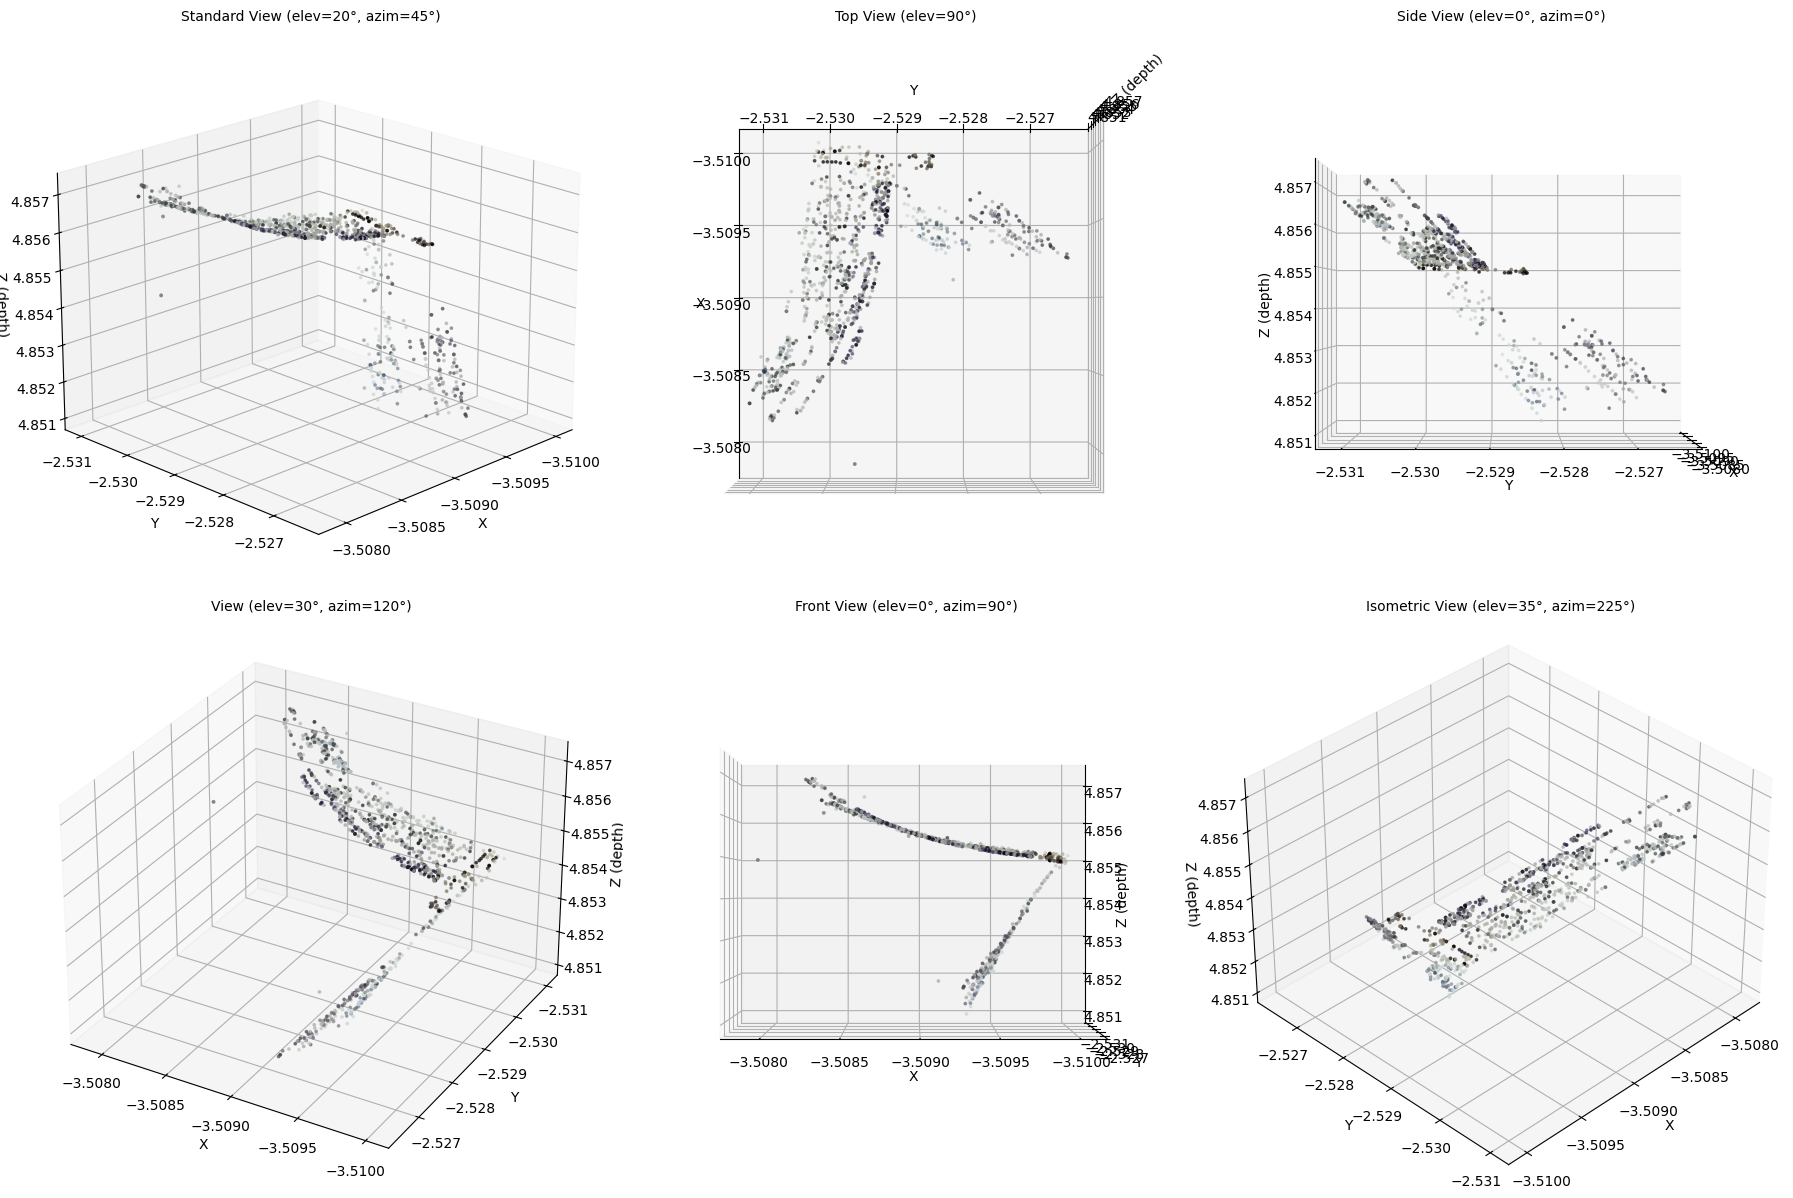

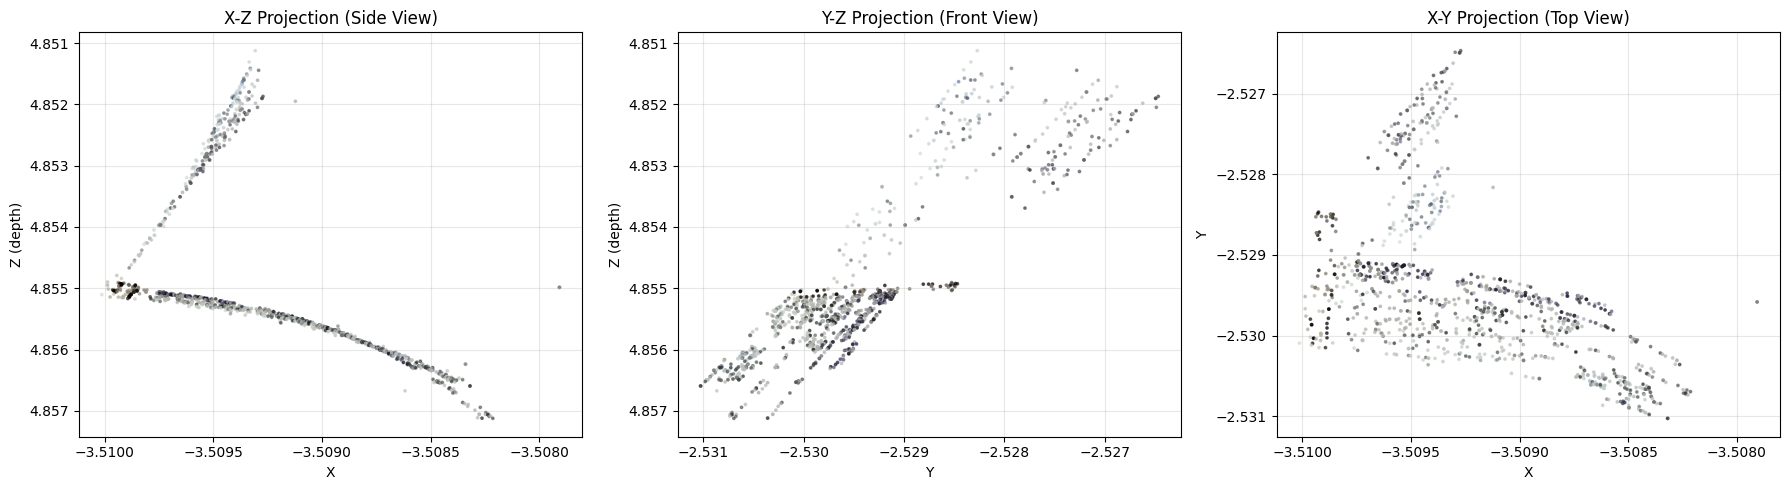


✓ Reconstruction complete!


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D





img1 = cv2.imread("E:/Uni/Fall 25-26/CV/Project/book1.jpg")
img2 = cv2.imread("E:/Uni/Fall 25-26/CV/Project/book2.jpg")



gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,4))
plt.subplot(121), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)), plt.title("Image 1")
plt.subplot(122), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), plt.title("Image 2")
plt.show()




sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)




good = []
pts1 = []
pts2 = []

for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

print("Good matches:", len(good))





img_matches = cv2.drawMatches(
    img1, kp1, img2, kp2, good[:50], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("Feature Matches Between Image 1 & Image 2")
plt.axis("off")
plt.show()


H, W = img1.shape[:2]
print(f"Image size: {W} × {H} pixels")

# Redmi Note 14 main camera specifications:
# - 24mm equivalent focal length (on 35mm full-frame)
# - 1/1.67" sensor (diagonal = 9.07mm)
# - f/1.7 aperture

crop_factor = 43.3 / 9.07  # 35mm diagonal / sensor diagonal
f_actual_mm = 24 / crop_factor  # ~5.03mm actual focal length

sensor_diag_mm = 9.07  



sensor_w_mm = sensor_diag_mm * (4 / 5)  
sensor_h_mm = sensor_diag_mm * (3 / 5)  



fx = f_actual_mm / sensor_w_mm * W
fy = f_actual_mm / sensor_h_mm * H
cx = W / 2
cy = H / 2

K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]], dtype=float)

print(f"\nCamera parameters:")
print(f"  Actual focal length: {f_actual_mm:.2f}mm")
print(f"  Sensor size: {sensor_w_mm:.2f} × {sensor_h_mm:.2f}mm")
print(f"  Focal length in pixels: fx={fx:.1f}, fy={fy:.1f}")
print(f"\nIntrinsic matrix K:")
print(np.round(K, 2))




E, mask_E = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)



pts1_inliers = pts1[mask_E.ravel() == 1]
pts2_inliers = pts2[mask_E.ravel() == 1]
print(f"\nRANSAC inliers: {len(pts1_inliers)} out of {len(pts1)}")

_, R, t, mask_pose = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)

print("\nRotation matrix R:")
print(np.round(R, 4))
print("\nTranslation vector t (unit norm):")
print(np.round(t.flatten(), 4))




P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = K @ np.hstack((R, t))

pts1_h = cv2.undistortPoints(np.expand_dims(pts1_inliers, axis=1), K, None)
pts2_h = cv2.undistortPoints(np.expand_dims(pts2_inliers, axis=1), K, None)

points_4d = cv2.triangulatePoints(P1, P2, pts1_h, pts2_h)
points_3d = points_4d[:3] / points_4d[3]

print(f"\nTriangulated 3D points: {points_3d.shape[1]}")


Z1 = points_3d[2]  


points_cam2 = R @ points_3d + t


Z2 = points_cam2[2]

print(f"  Points with positive depth in camera 1: {np.sum(Z1 > 0)}")
print(f"  Points with positive depth in camera 2: {np.sum(Z2 > 0)}")



valid_mask = (Z1 > 0) & (Z2 > 0)
print(f"  Points in front of both cameras: {np.sum(valid_mask)}")

if np.sum(valid_mask) == 0:
    print("\n WARNING: No valid points!")
    print("Showing all points without filtering...")
    valid_mask = np.ones(points_3d.shape[1], dtype=bool)

points_3d_filtered = points_3d[:, valid_mask]
pts1_valid = pts1_inliers[valid_mask]




if np.sum(valid_mask) > 20:
    distances = np.linalg.norm(points_3d_filtered, axis=0)
    
    p5 = np.percentile(distances, 5)
    p95 = np.percentile(distances, 95)
    
    outlier_mask = (distances >= p5) & (distances <= p95)
    print(f"  After outlier removal: {np.sum(outlier_mask)} points")
    
    points_3d_filtered = points_3d_filtered[:, outlier_mask]
    pts1_valid = pts1_valid[outlier_mask]

X = points_3d_filtered[0]
Y = points_3d_filtered[1]
Z = points_3d_filtered[2]

print(f"\n Final point cloud: {len(X)} points")

if len(X) > 0:
    print(f"\nPoint cloud statistics:")
    print(f"  X range: [{X.min():.3f}, {X.max():.3f}], span: {X.max()-X.min():.3f}")
    print(f"  Y range: [{Y.min():.3f}, {Y.max():.3f}], span: {Y.max()-Y.min():.3f}")
    print(f"  Z range: [{Z.min():.3f}, {Z.max():.3f}], span: {Z.max()-Z.min():.3f}")
    print(f"  Mean depth: {Z.mean():.3f}")
    print(f"  Depth std dev: {Z.std():.3f}")




colors = []
for pt in pts1_valid:
    x, y = int(pt[0]), int(pt[1])
    if 0 <= x < W and 0 <= y < H:
        b, g, r = img1[y, x]
        colors.append([r/255.0, g/255.0, b/255.0])
    else:
        colors.append([0.5, 0.5, 0.5])
colors = np.array(colors)


if len(X) > 0:
    fig = plt.figure(figsize=(18, 12))
    
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.scatter(X, Y, Z, c=colors, s=3, alpha=0.6)
    ax1.set_title("Standard View (elev=20°, azim=45°)", fontsize=10)
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z (depth)")
    ax1.view_init(elev=20, azim=45)
    
    ax2 = fig.add_subplot(232, projection='3d')
    ax2.scatter(X, Y, Z, c=colors, s=3, alpha=0.6)
    ax2.set_title("Top View (elev=90°)", fontsize=10)
    ax2.set_xlabel("X")
    ax2.set_ylabel("Y")
    ax2.set_zlabel("Z (depth)")
    ax2.view_init(elev=90, azim=0)
    
    ax3 = fig.add_subplot(233, projection='3d')
    ax3.scatter(X, Y, Z, c=colors, s=3, alpha=0.6)
    ax3.set_title("Side View (elev=0°, azim=0°)", fontsize=10)
    ax3.set_xlabel("X")
    ax3.set_ylabel("Y")
    ax3.set_zlabel("Z (depth)")
    ax3.view_init(elev=0, azim=0)
    
    ax4 = fig.add_subplot(234, projection='3d')
    ax4.scatter(X, Y, Z, c=colors, s=3, alpha=0.6)
    ax4.set_title("View (elev=30°, azim=120°)", fontsize=10)
    ax4.set_xlabel("X")
    ax4.set_ylabel("Y")
    ax4.set_zlabel("Z (depth)")
    ax4.view_init(elev=30, azim=120)
    
    ax5 = fig.add_subplot(235, projection='3d')
    ax5.scatter(X, Y, Z, c=colors, s=3, alpha=0.6)
    ax5.set_title("Front View (elev=0°, azim=90°)", fontsize=10)
    ax5.set_xlabel("X")
    ax5.set_ylabel("Y")
    ax5.set_zlabel("Z (depth)")
    ax5.view_init(elev=0, azim=90)
    
    
    ax6 = fig.add_subplot(236, projection='3d')
    ax6.scatter(X, Y, Z, c=colors, s=3, alpha=0.6)
    ax6.set_title("Isometric View (elev=35°, azim=225°)", fontsize=10)
    ax6.set_xlabel("X")
    ax6.set_ylabel("Y")
    ax6.set_zlabel("Z (depth)")
    ax6.view_init(elev=35, azim=225)
    
    plt.tight_layout()
    plt.show()
    
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    
    axes[0].scatter(X, Z, c=colors, s=3, alpha=0.6)
    axes[0].set_title("X-Z Projection (Side View)")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Z (depth)")
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3)
    
   
    axes[1].scatter(Y, Z, c=colors, s=3, alpha=0.6)
    axes[1].set_title("Y-Z Projection (Front View)")
    axes[1].set_xlabel("Y")
    axes[1].set_ylabel("Z (depth)")
    axes[1].invert_yaxis()
    axes[1].grid(True, alpha=0.3)
    
    
    axes[2].scatter(X, Y, c=colors, s=3, alpha=0.6)
    axes[2].set_title("X-Y Projection (Top View)")
    axes[2].set_xlabel("X")
    axes[2].set_ylabel("Y")
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n Reconstruction complete!")
else:
    print("\n Cannot visualize: No valid 3D points")